# Лабораторная работа №2 — Линейные модели
## Вариант 3: Регрессия и Классификация

**Цель работы:** изучить применение линейной и логистической регрессии для решения практических задач машинного обучения.

**Датасеты:**
- `auto-mpg.csv` — прогноз расхода топлива (регрессия)
- `pima-indians-diabetes.csv` — диагностика диабета (классификация)


## Часть 1. Регрессия — прогноз расхода топлива (Auto MPG)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Загрузка данных
auto = pd.read_csv('auto-mpg.csv')


# Быстрый просмотр
display(auto.head())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Предобработка данных
Проверим наличие пропусков и категориальных признаков, удалим строки с отсутствующими значениями в `horsepower`.

In [23]:
# ---------- Регрессия: предобработка Auto MPG ----------
# Обработка пропусков в horsepower
auto = auto.copy()
auto.replace('?', np.nan, inplace=True)
auto.dropna(subset=['horsepower'], inplace=True)
auto['horsepower'] = auto['horsepower'].astype(float)

# Обработка категориального признака origin (1,2,3 -> 'USA','Europe','Japan')
auto['origin'] = auto['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
origin_dummies = pd.get_dummies(auto['origin'], prefix='origin', drop_first=True)
auto = pd.concat([auto, origin_dummies], axis=1)
print('Созданные дамми-столбцы для origin:', list(origin_dummies.columns))

# Выбираем признаки по заданию: cylinders, horsepower, weight
features = ['cylinders', 'horsepower', 'weight']
X = auto[features]
y = auto['mpg']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение линейной регрессии
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Предсказания и метрики
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE (Linear Regression): {mse:.2f}')
print(f'R² (Linear Regression): {r2:.3f}')

Созданные дамми-столбцы для origin: ['origin_Japan', 'origin_USA']
MSE (Linear Regression): 17.68
R² (Linear Regression): 0.654


### Визуализация зависимости `mpg` от `horsepower`

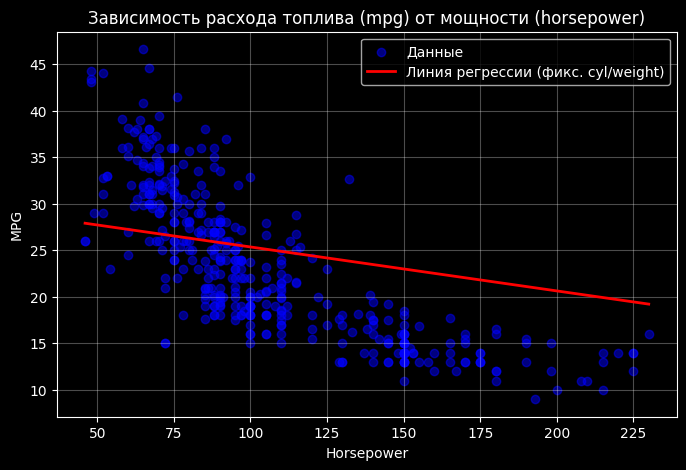

In [24]:
# ---------- Визуализация: mpg vs horsepower с линией регрессии ----------
plt.figure(figsize=(8,5))
plt.scatter(auto['horsepower'], auto['mpg'], color='blue', alpha=0.5, label='Данные')

# Построим линию предсказаний при фиксированных значениях cylinders и weight
hp_range = np.linspace(auto['horsepower'].min(), auto['horsepower'].max(), 200)
plot_df = pd.DataFrame({
    'cylinders': np.full_like(hp_range, int(auto['cylinders'].mode()[0])),
    'horsepower': hp_range,
    'weight': np.full_like(hp_range, int(auto['weight'].median()))
})

# Предсказание и отрисовка линии регрессии
mpg_pred_line = lin_reg.predict(plot_df)
plt.plot(hp_range, mpg_pred_line, color='red', linewidth=2, label='Линия регрессии (фикс. cyl/weight)')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Зависимость расхода топлива (mpg) от мощности (horsepower)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Вывод:**
Модель линейной регрессии показывает, как мощность и вес автомобиля влияют на расход топлива. Отрицательная зависимость между `horsepower` и `mpg` говорит о том, что с увеличением мощности расход топлива возрастает.

## Часть 2. Классификация — диагностика диабета (Pima Indians Diabetes)

In [ ]:
# Pima dataset — в файле нет заголовка, строки с описанием начинаются с '#'
col_names = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
diabetes = pd.read_csv('pima-indians-diabetes.csv', comment='#', header=None, names=col_names)


# ---------- Классификация: загрузка и просмотр Pima Indians Diabetes ----------
display(diabetes.head())
diabetes.info()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Подготовка данных и стандартизация признаков

In [26]:
# ---------- Классификация: подготовка, стандартизация и обучение логистической регрессии ----------
# Разделение признаков и целевой переменной
X_clf = diabetes.drop('Outcome', axis=1)
y_clf = diabetes['Outcome']

# Стандартизация признаков
scaler = StandardScaler()
X_clf_scaled = scaler.fit_transform(X_clf)

# Разделение на train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf_scaled, y_clf, test_size=0.2, random_state=42)

# Обучение логистической регрессии
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_clf, y_train_clf)

# Предсказания и метрики
y_pred_clf = log_reg.predict(X_test_clf)
acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf)
rec = recall_score(y_test_clf, y_pred_clf)
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall: {rec:.3f}')

Accuracy: 0.753
Precision: 0.649
Recall: 0.673


### Матрица ошибок

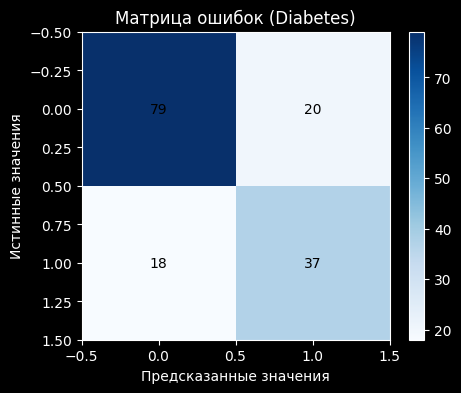

False Positives (FP): 20
False Negatives (FN): 18
True Positives (TP): 37
True Negatives (TN): 79


In [27]:
# ---------- Матрица ошибок для классификации ----------
cm = confusion_matrix(y_test_clf, y_pred_clf)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xlabel('Предсказанные значения')
ax.set_ylabel('Истинные значения')
ax.set_title('Матрица ошибок (Diabetes)')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.colorbar(im, ax=ax)
plt.show()

# Вывод о ложноположительных и ложноотрицательных срабатываниях
tn, fp, fn, tp = cm.ravel()
print('False Positives (FP):', fp)
print('False Negatives (FN):', fn)
print('True Positives (TP):', tp)
print('True Negatives (TN):', tn)

**Вывод:**
Модель логистической регрессии адекватно классифицирует наличие диабета. Ложноположительные срабатывания означают, что модель ошибочно определила диабет у здорового человека, а ложноотрицательные — пропустила болезнь.